In [1]:
#import modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf 

%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

### Preparing Data

In [18]:
#import stock data from yfinance
def data_prep(symbol):
    df = yf.download(tickers=symbol).dropna()
    return df

df = data_prep('AAPL')

[*********************100%%**********************]  1 of 1 completed


In [19]:
#Caculate the fast and slow moving averages using the closing price
df["20-day SMA"] = df["Close"].rolling(20).mean()
df["50-day SMA"] = df["Close"].rolling(50).mean()

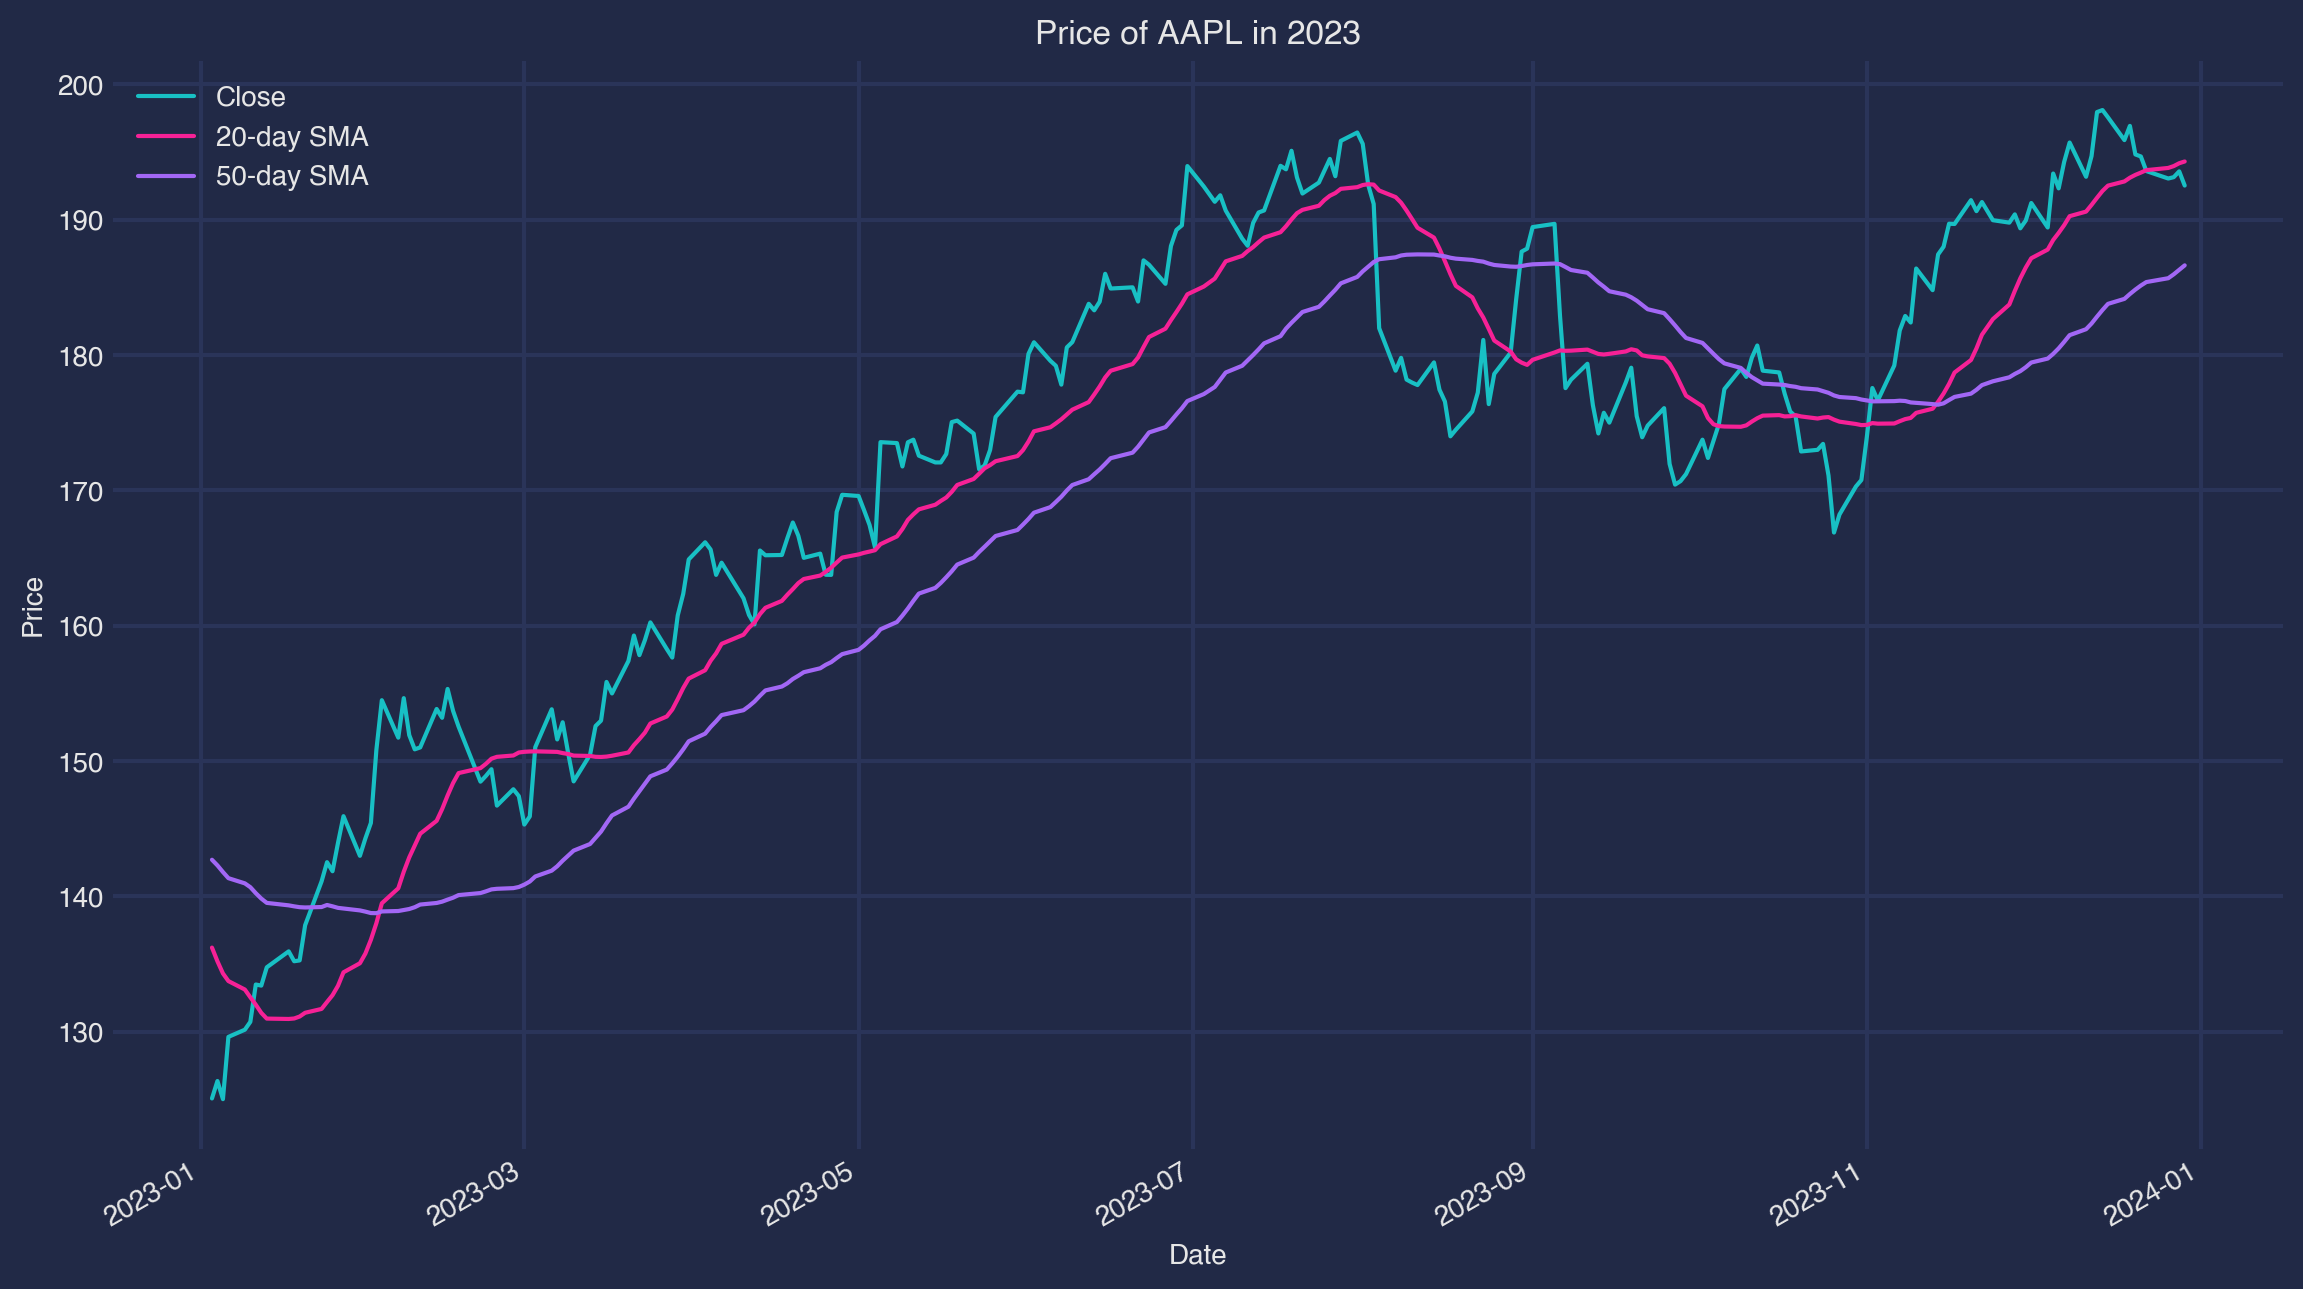

In [20]:
df[["Close", "20-day SMA", "50-day SMA"]].loc["2023"].plot(figsize=(14,8))
plt.legend()
plt.title('Price of AAPL in 2023')
plt.ylabel("Price")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/'
              'pitayasmoothie-dark.mplstyle')
plt.grid(linewidth=1.5)

### Creating Trading Signals

In [21]:
#Create signals to buy and sell the asset using moving average crossovers
df['signal'] = np.nan
df.loc[(df['20-day SMA'] > df['50-day SMA']) & (df['20-day SMA'].shift(1) <= df['50-day SMA'].shift(1)), 'signal'] = 1
df.loc[(df['20-day SMA'] < df['50-day SMA']) & (df['20-day SMA'].shift(1) >= df['50-day SMA'].shift(1)), 'signal'] = -1
idx_open = df.loc[df["signal"] == 1].loc["2023"].index
idx_close = df.loc[df["signal"] == -1].loc["2023"].index

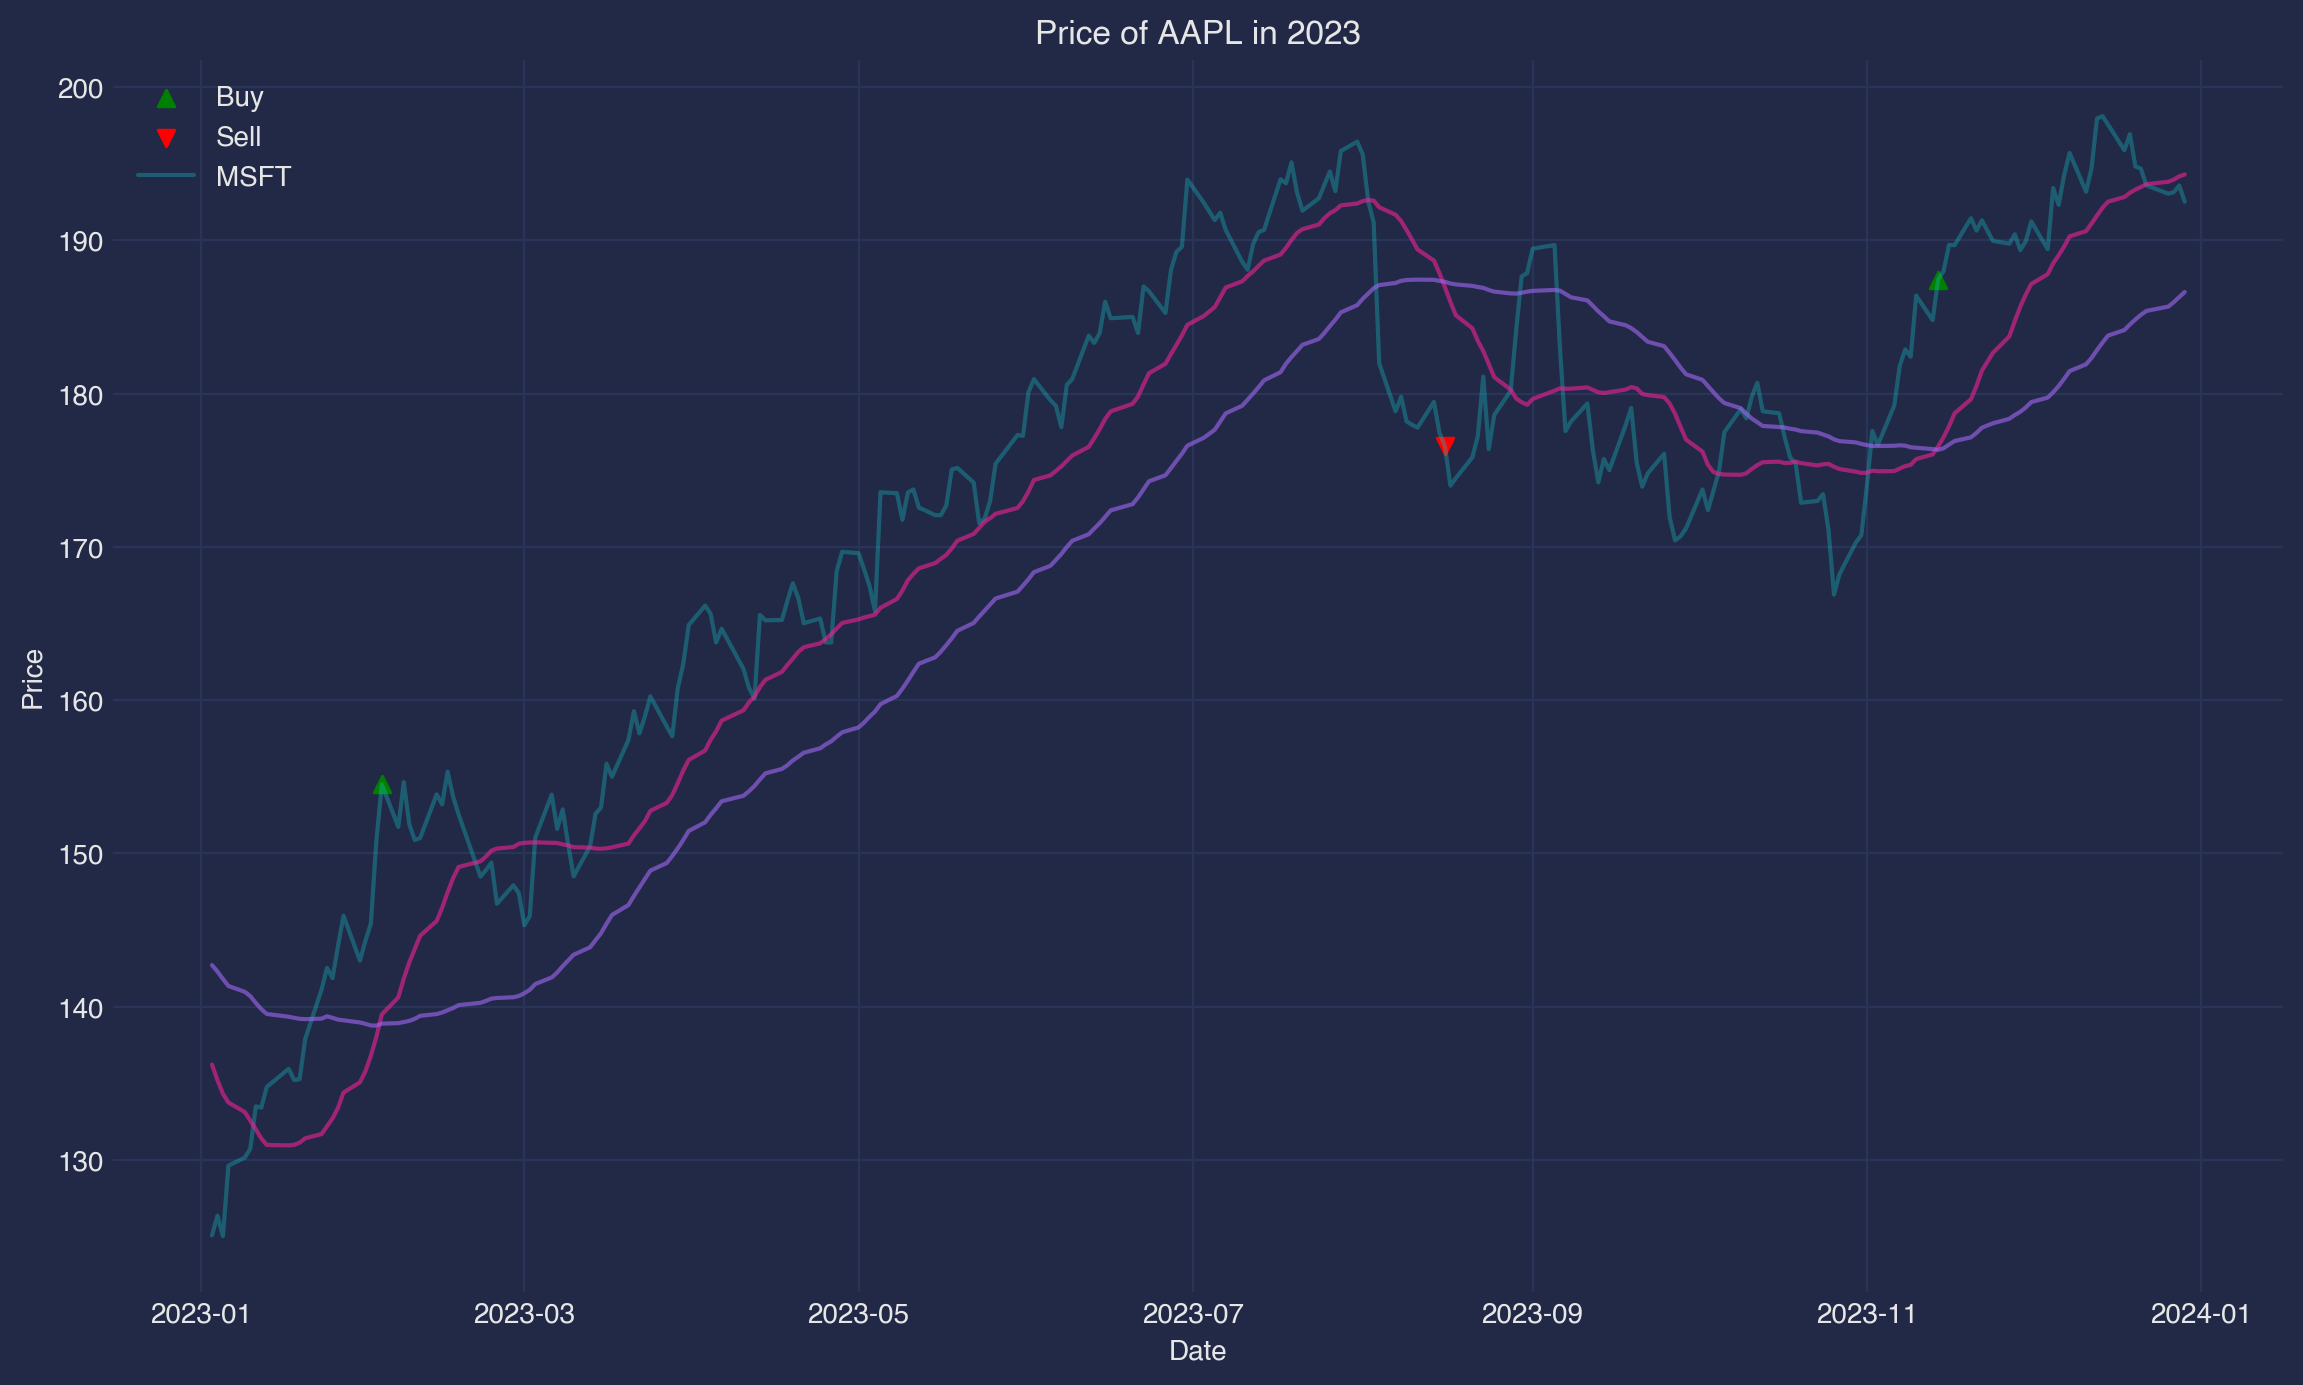

In [22]:
plt.figure(figsize=(14,8))
plt.scatter(idx_open, df.loc[idx_open]["Close"].loc["2023"], color="green", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["Close"].loc["2023"], color="red", marker="v")
plt.plot(df["Close"].loc["2023"].index, df["Close"].loc["2023"], alpha=0.35)
plt.plot(df["Close"].loc["2023"].index, df["20-day SMA"].loc["2023"], alpha=0.6)
plt.plot(df["Close"].loc["2023"].index, df["50-day SMA"].loc["2023"], alpha=0.6)
plt.legend(["Buy", "Sell", "MSFT"])
plt.title('Price of AAPL in 2023')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

### Computing Returns

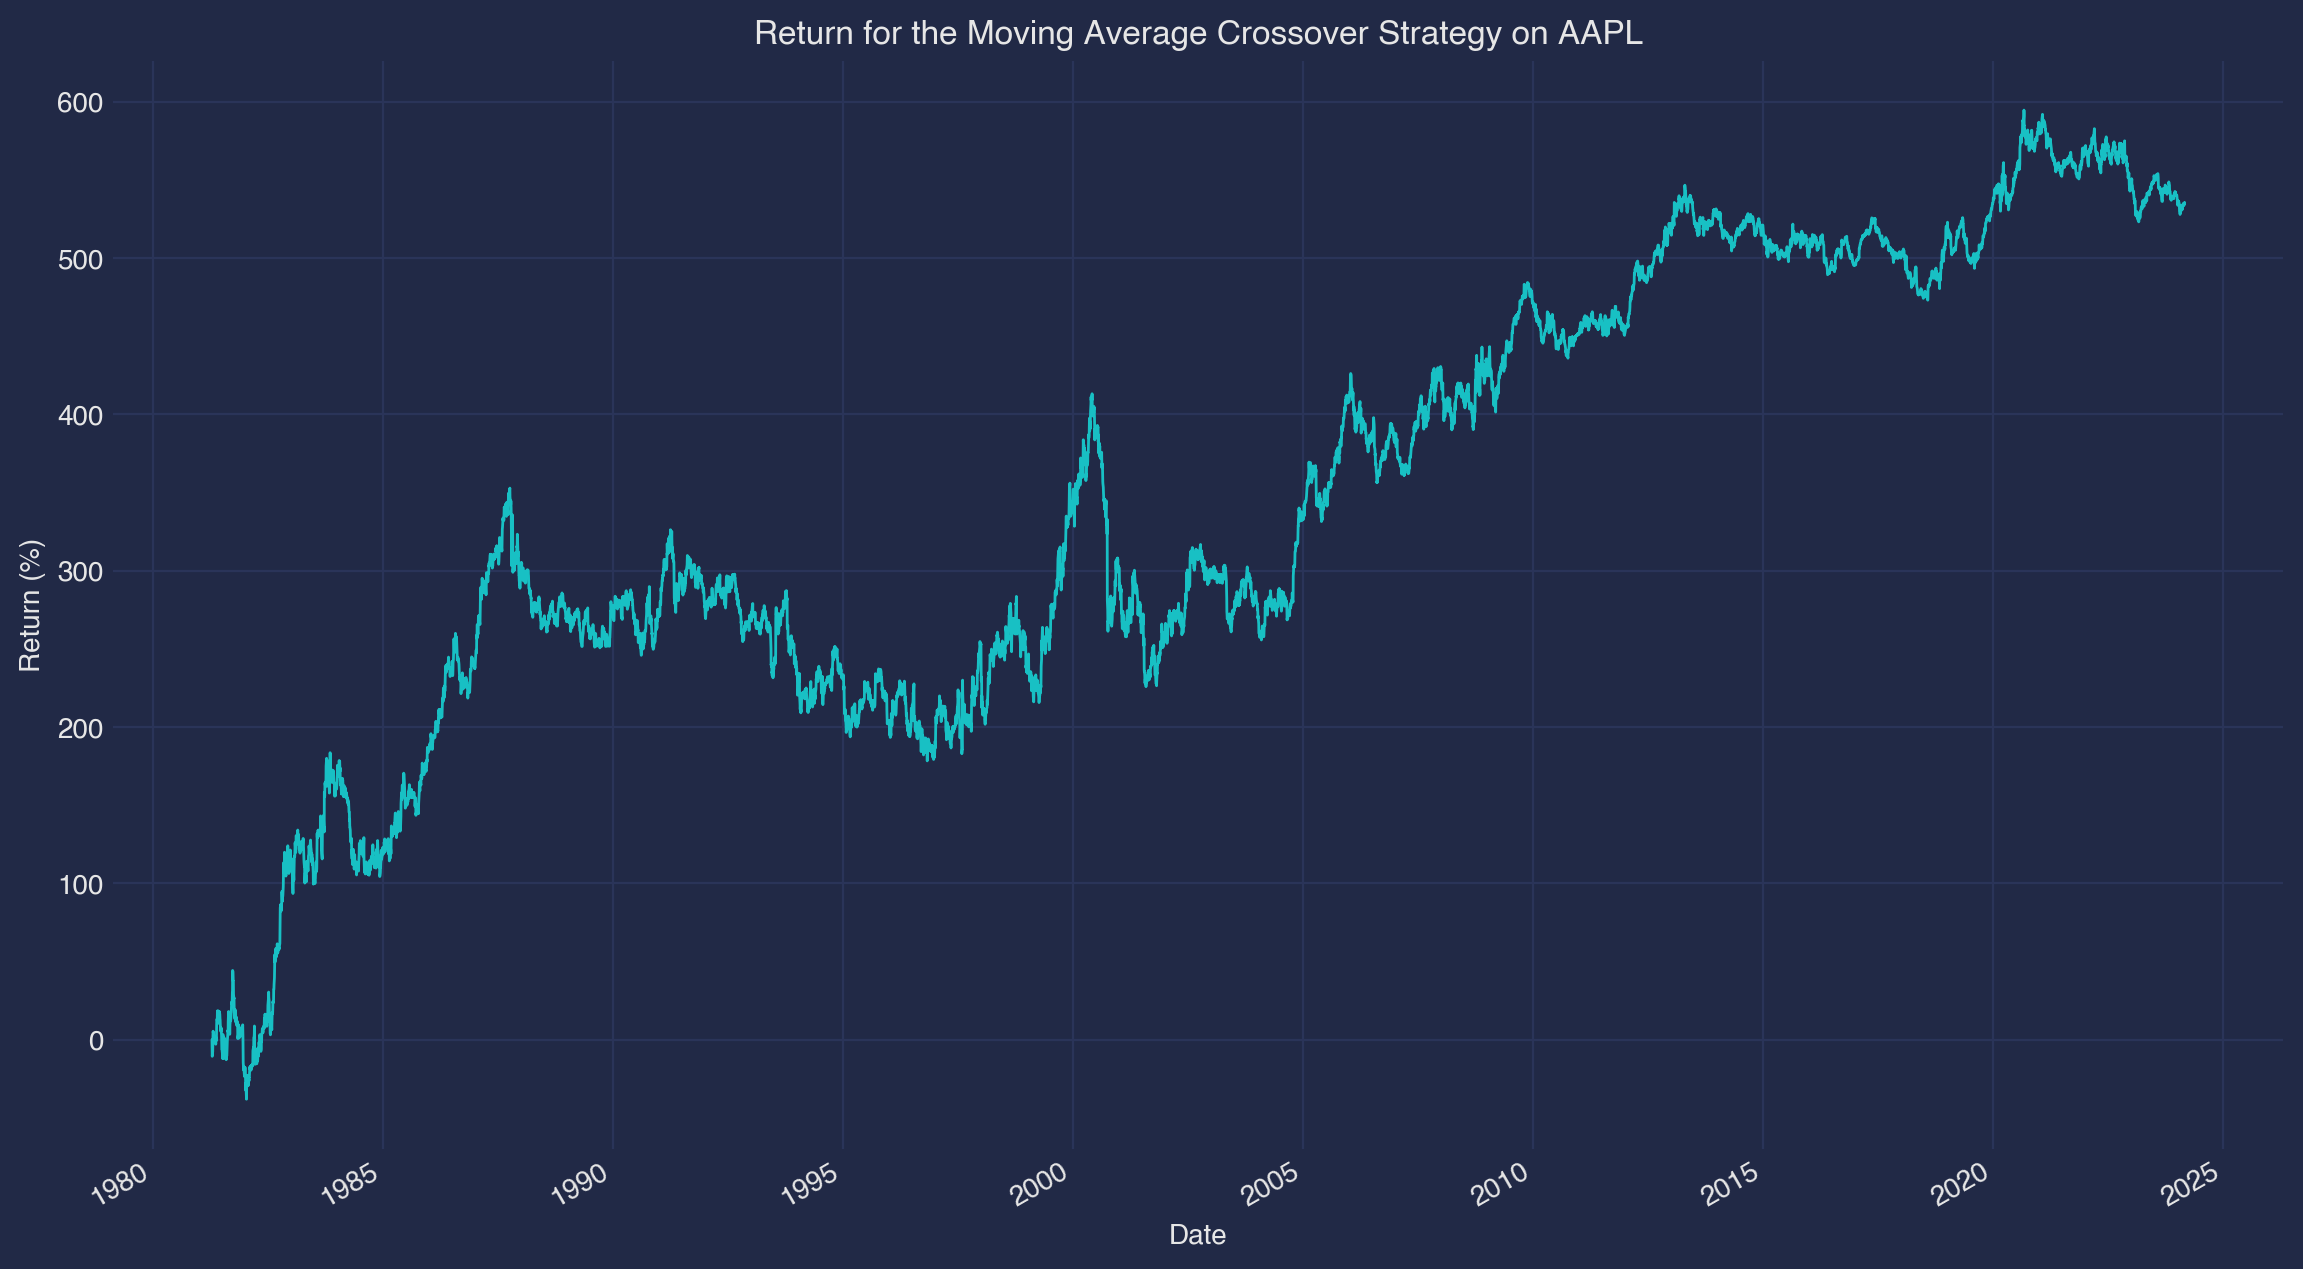

In [23]:
#Computing the returns net of costs 
df["position"] = df["signal"].ffill()
cost = 0.0001
df["cost"] = (np.abs(df["signal"]) * cost).fillna(value=0)
df["return"] = (df["Close"].pct_change(1) * df["position"].shift(1) - df["cost"]) * 100
df["return"].cumsum().plot(figsize=(14,8), linewidth=1, title="Return for the Moving Average Crossover Strategy on AAPL")
plt.ylabel("Return (%)")
plt.show()

### Automating the process

[*********************100%%**********************]  1 of 1 completed


(<Axes: title={'center': 'Return for the Moving Average Crossover Strategy'}, xlabel='Date', ylabel='Return (%)'>,
 Text(0, 0.5, 'Return (%)'))

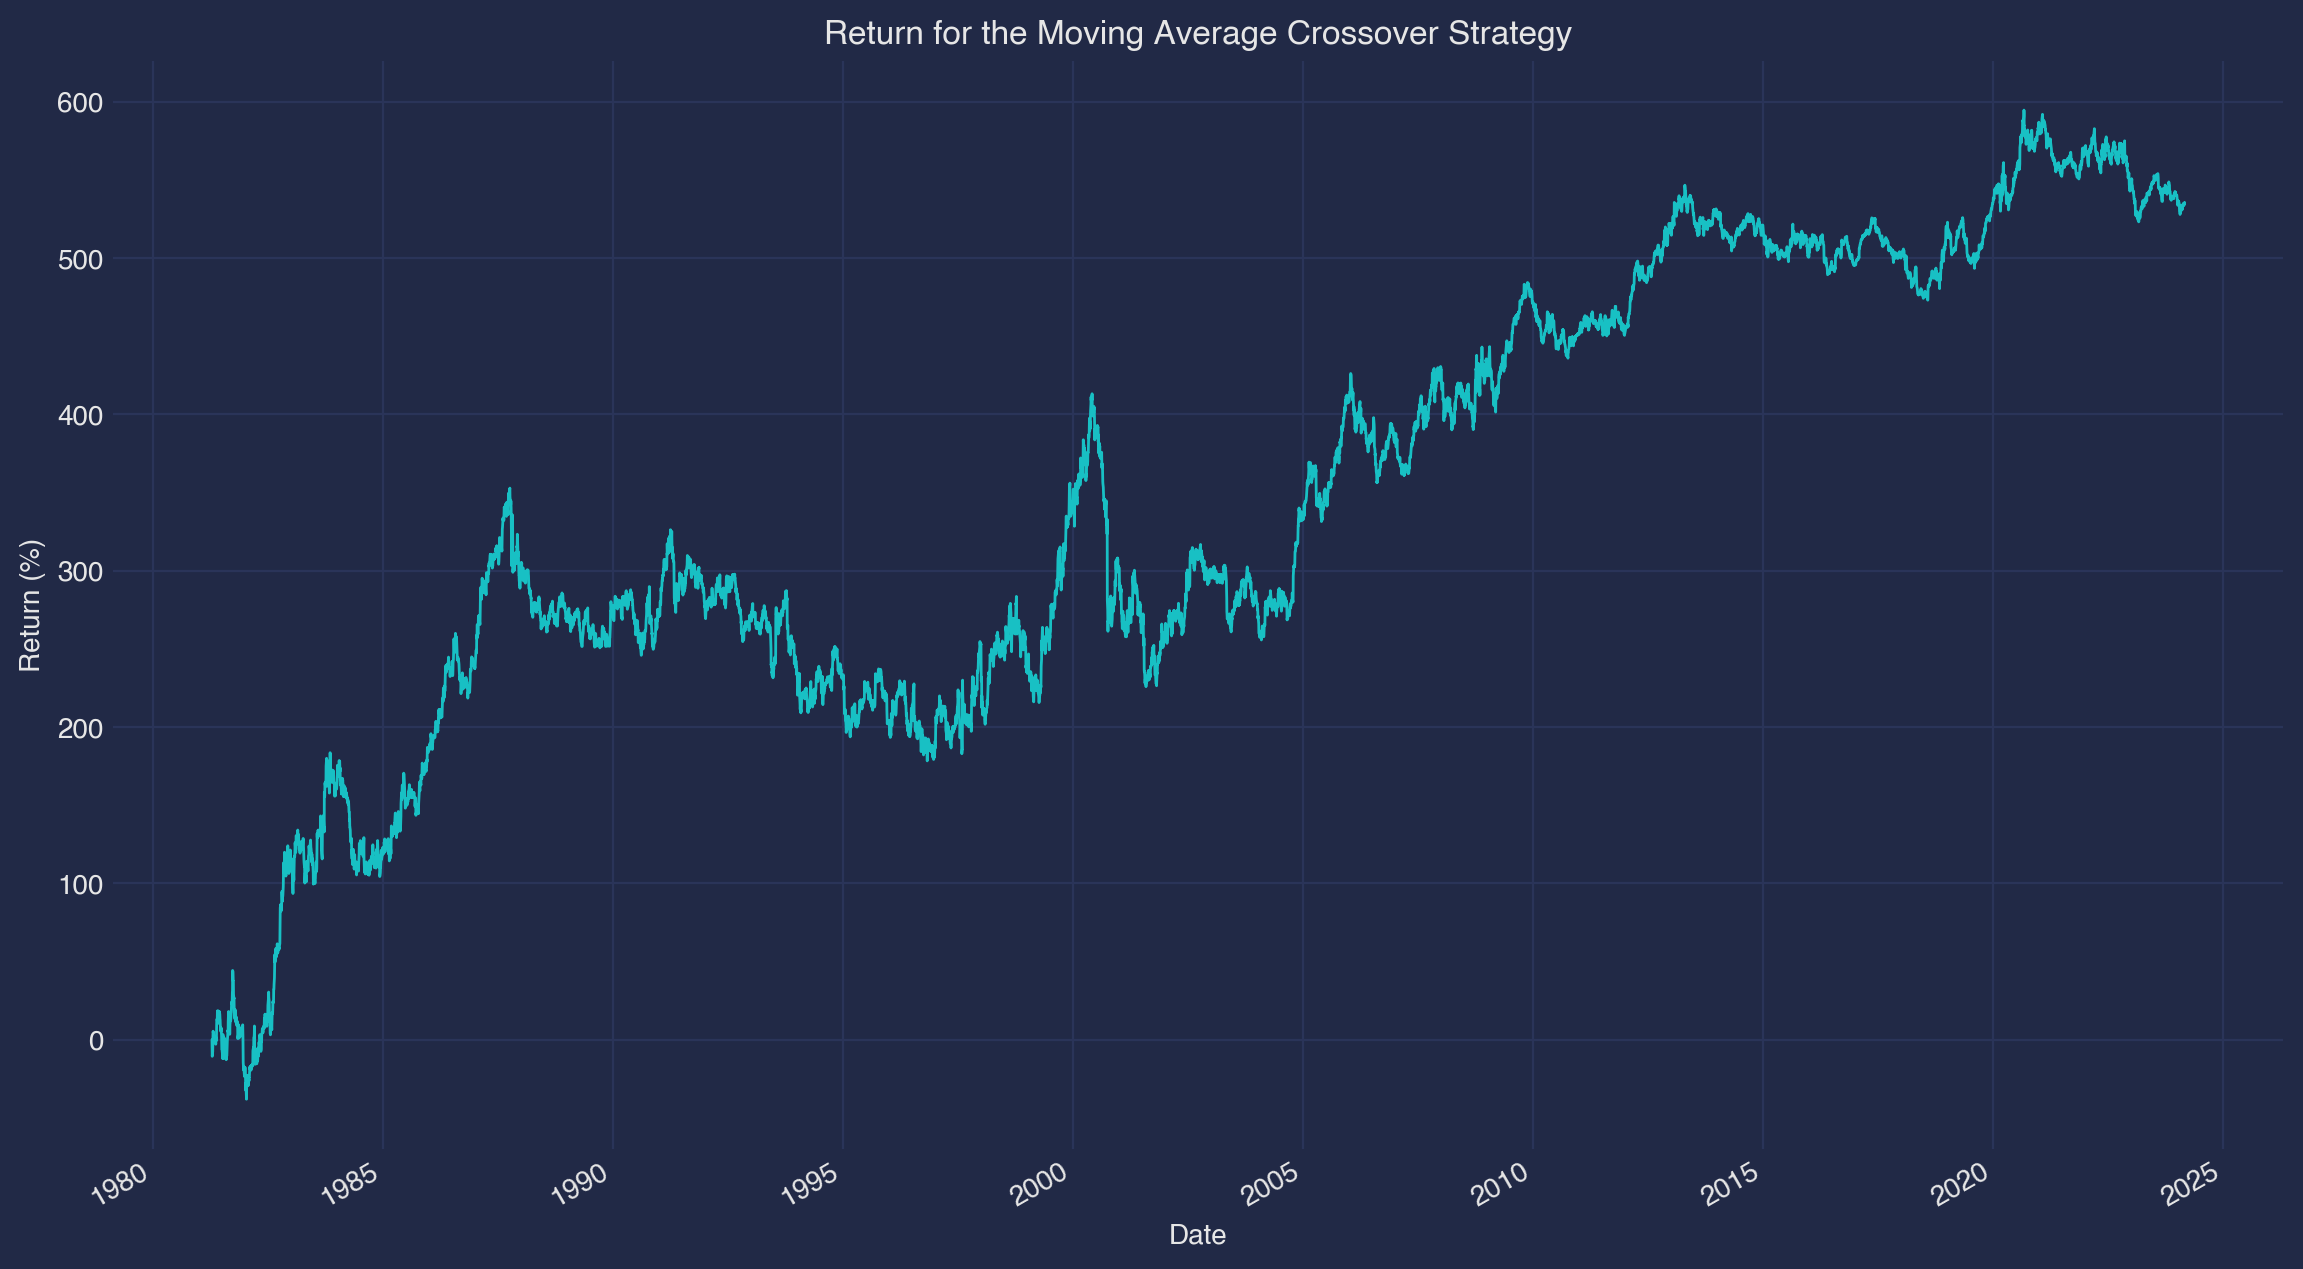

In [24]:
def SMA_strategy (input, fast_sma, slow_sma, cost):
    df = data_prep(input)
    df["fast_sma"] = df["Close"].rolling(fast_sma).mean()
    df["slow_sma"] = df["Close"].rolling(slow_sma).mean()
    df["signal"] = np.nan
    buy_condition = df.loc[(df['fast_sma'] > df['slow_sma']) & (df['fast_sma'].shift(1) <= df['slow_sma'].shift(1)), 'signal'] = 1
    sell_condition = df.loc[(df['fast_sma'] < df['slow_sma']) & (df['fast_sma'].shift(1) >= df['slow_sma'].shift(1)), 'signal'] = -1
    df["position"] = df["signal"].ffill()
    df["cost"] = (np.abs(df["signal"]) * cost).fillna(value=0)
    df["return"] = (df["Close"].pct_change() * df["position"].shift(1) - df["cost"]) * 100
    return df["return"].cumsum().plot(figsize=(14,8), linewidth=1, title="Return for the Moving Average Crossover Strategy"), plt.ylabel("Return (%)")
            
SMA_strategy('AAPL',20,50,0.0001)